# 소프트맥스 선형 회귀
---

## 1) 패키지 준비하기

In [1]:
from pandas import read_excel
from pandas import DataFrame
from pandas import merge
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# (신규) 예제에서 사용할 데이터셋을 다운로드 받기 위한 함수
from tensorflow.keras.datasets.mnist import load_data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## 2) 데이터셋 준비하기

In [2]:
(x_train, y_train), (x_test, y_test) = load_data(path='mnist.npz')

11493376/11490434 [==============================] - 0s 0us/step


## 3) 데이터 전처리

### 결측치 확인

- 결측치 등의 데이터 이상점이 없는 예제 데이터 이므로 생략

## 4) 탐색적 데이터 분석

### 훈련 데이터 형태 확인

In [3]:
print(x_train.shape, y_train.shape)
print(y_train)

(60000, 28, 28) (60000,)
[5 0 4 ... 5 6 8]


### 검증 데이터의 형태 확인

In [4]:
print(x_test.shape, y_test.shape)
print(y_test)

(10000, 28, 28) (10000,)
[7 2 1 ... 4 5 6]


### 임의의 샘플 값 확인

In [5]:
for i in x_train[1]:
    for j in i:
        print("%03d" % j, end="")
    print()

000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000051159253159050000000000000000000000000
000000000000000000000000000000000000000000048238252252252237000000000000000000000000
000000000000000000000000000000000000000054227253252239233252057006000000000000000000
000000000000000000000000000000000010060224252253252202084252253122000000000000000000
000000000000000000000000000000000163252252252253252252096189253167000000000000000000
000000000000000000000000000000051238253253190114253228047079255168000000000000000000
000000000000000000000000000048238252252179012075121021000000253243050000000000000000
00000000000000000000000003816525323320808400000000000000000025325

In [6]:
print(y_train[1])

0


### 데이터 그려보기

mnist 데이터셋은 0~9까지 가로 28px, 세로 28px 크기의 이미지 60000장 + 10000장 데이터.

글자를 표현하는 간단한 이미지이므로 배경색을 단색으로 처리하고 글자가 표시되는 영역의 색상을 노란색으로 표현.

색상값은 0~255 사이의 10진 정수.

그러므로 이미지 데이터들은 이미지 픽셀 크기 만큼의 2차 배열의 각 원소가 색상값을 의미하는 숫자로 구성된 데이터로 표현가능.

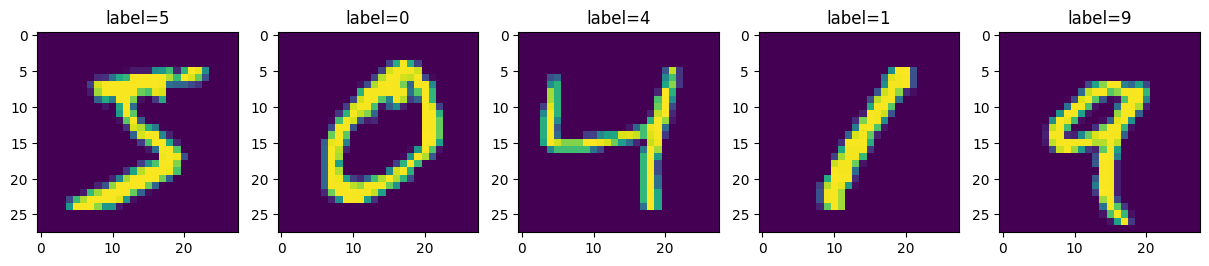

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3), dpi=100)

for i in range(0, len(ax)):
    train = x_train[i]
    label = y_train[i]
    ax[i].imshow(train)
    ax[i].set_title("label=%d" % label)

plt.show()
plt.close()

## 5) 데이터셋 분할하기

### 랜덤시드 고정

In [8]:
np.random.seed(777)

### 훈련 데이터와 검증 데이터로 분할

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.3, random_state = 777)
print(f'훈련 데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증 데이터 {x_test.shape} 레이블 {y_test.shape}')

훈련 데이터 (42000, 28, 28) 레이블 (42000,)
검증 데이터 (18000, 28, 28) 레이블 (18000,)


### one-hot-encoding

In [10]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 훈련, 검증용 독립변수(이미지)의 차수 재설정
훈련 데이터의 shape가 (20580, 28, 28)라는 것은 가로 28, 세로 28 크기의 이미지가 20580장 이라는 의미.

즉, 20580개의 2차원 배열을 학습해야 하는 것 보다 20580개의 784(28*28)개의 원소를 갖는 1차원 배열을 학습하는 것이 학습 효율이 더 좋다.

In [11]:
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])
print(f'훈련 데이터 {x_train_reshape.shape} / 검증 데이터 {x_train_reshape.shape}')
print(x_train_reshape[0])

훈련 데이터 (42000, 784) / 검증 데이터 (42000, 784)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  25 126 208 254 226  12   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  15 211
 254 253 253 253 102   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0 140 253 254 253 253 253 185   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
 188 253 254 253 253 253 206   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  65 241 254 218 253 253 171   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 

### 이미지 데이터 정규화

각 픽셀의 색상값은 0~255사이의 값을 갖는다.

그러므로 색상값을 255로 나누면 0~1 사이의 범위를 갖도록 데이터 정규화가 수행된다.

In [12]:
x_train_normal = x_train_reshape / 255
x_test_normal = x_test_reshape / 255
x_train_normal[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

## 6) 모델 개발

### 모델 정의

In [13]:
model = Sequential()
model.add(Dense(256, input_shape=(len(x_train_normal[0]), ), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


### 학습하기

In [14]:
result = model.fit(x_train_normal, y_train_one_hot, epochs=500, validation_data=(x_test_normal, y_test_one_hot), callbacks = [
    #ModelCheckpoint(filepath = 'check_point.h5', monitor = 'val_loss', verbose=1, save_best_only = True),
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/500
1313/1313 [==============================] - 3s 2ms/step - loss: 0.2475 - acc: 0.9260 - val_loss: 0.1575 - val_acc: 0.9516
Epoch 2/500
1313/1313 [==============================] - 2s 2ms/step - loss: 0.1060 - acc: 0.9674 - val_loss: 0.1120 - val_acc: 0.9660
Epoch 3/500
1313/1313 [==============================] - 2s 2ms/step - loss: 0.0734 - acc: 0.9767 - val_loss: 0.1354 - val_acc: 0.9604.0731 - ac
Epoch 4/500
1313/1313 [==============================] - 2s 2ms/step - loss: 0.0534 - acc: 0.9835 - val_loss: 0.1006 - val_acc: 0.9697
Epoch 5/500
1313/1313 [==============================] - 2s 2ms/step - loss: 0.0415 - acc: 0.9864 - val_loss: 0.1050 - val_acc: 0.9726TA: 0s - loss: 0.0408 - acc:
Epoch 6/500
1313/1313 [==============================] - 2s 2ms/step - loss: 0.0356 - acc: 0.9889 - val_loss: 0.1032 - val_acc: 0.9736
Epoch 7/500
1313/1313 [==============================] - 2s 2ms/step - loss: 0.0308 - acc: 0.9903 - val_loss: 0.0969 - val_acc: 0.9754
Epoch 8/500
1313/

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.247517,0.925976,0.157462,0.951611,0.0010
2,0.105987,0.967357,0.111977,0.966000,0.0010
3,0.073434,0.976690,0.135410,0.960444,0.0010
4,0.053370,0.983548,0.100559,0.969722,0.0010
5,0.041501,0.986405,0.105034,0.972556,0.0010
6,0.035557,0.988881,0.103189,0.973611,0.0010
7,0.030781,0.990262,0.096862,0.975444,0.0010
8,0.025342,0.991643,0.091680,0.975778,0.0010
9,0.022245,0.992595,0.108687,0.976167,0.0010


## 7) 학습 결과 평가

### 학습 결과 시각화

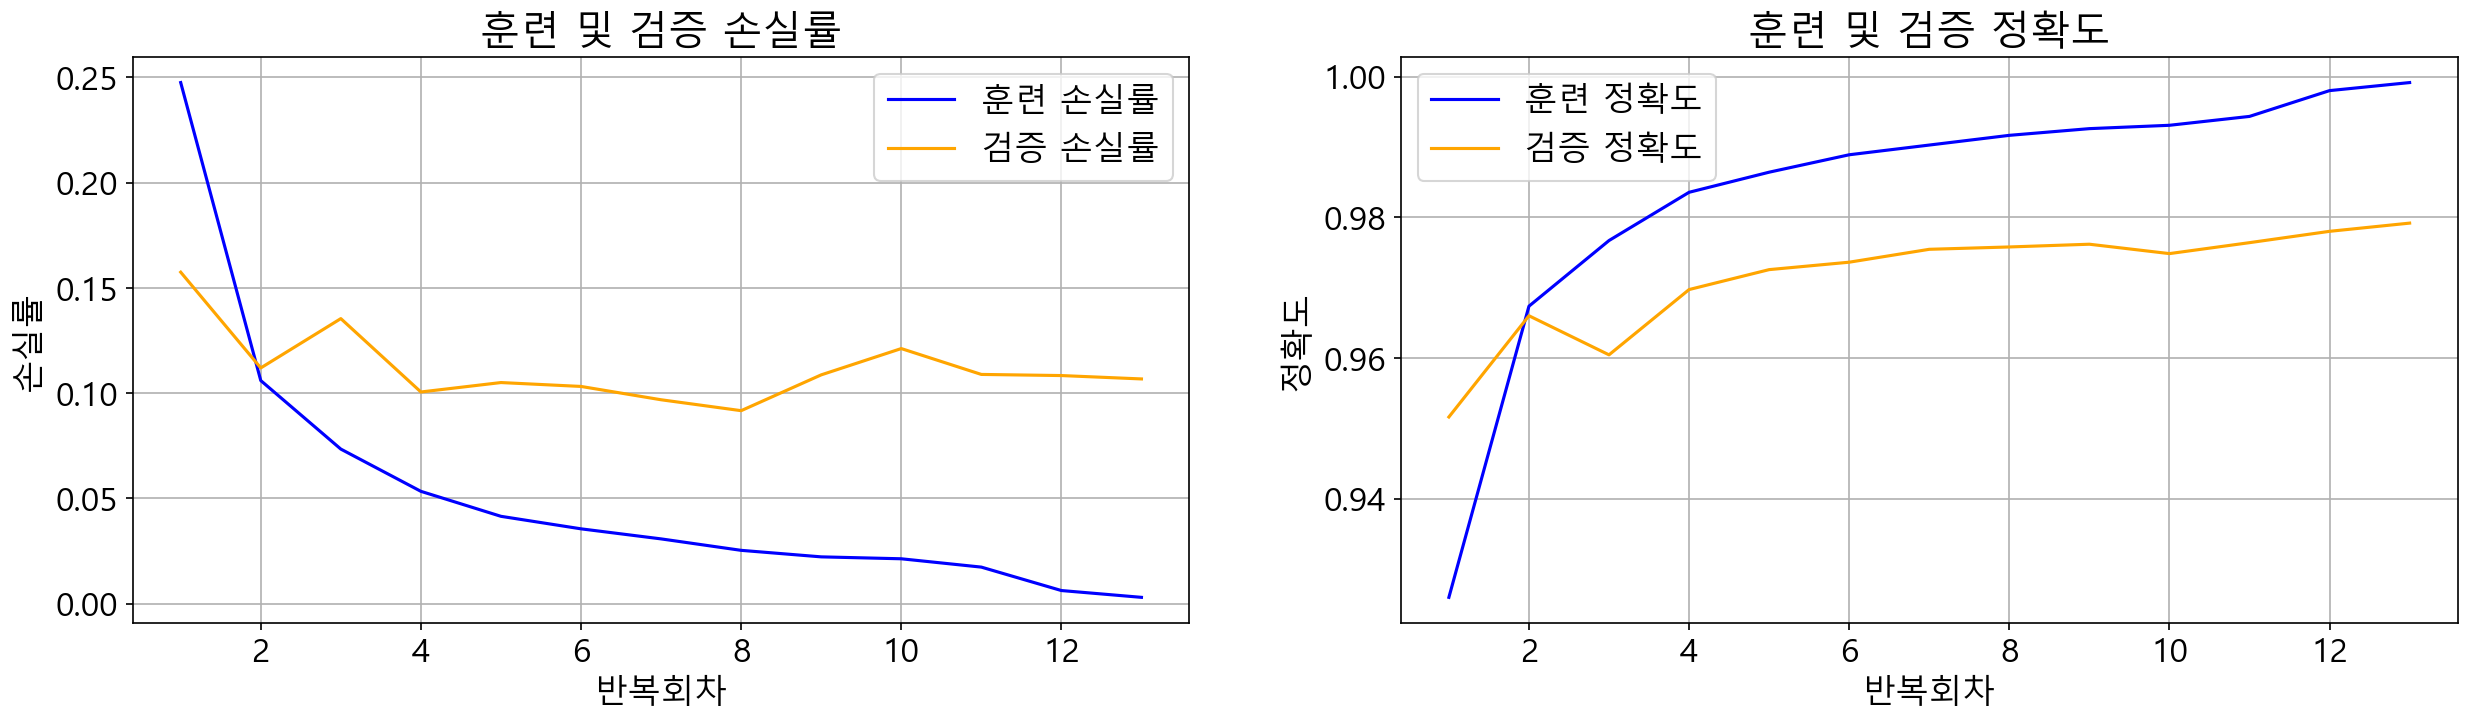

In [15]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='acc', data=result_df, color = 'blue', label = '훈련 정확도', ax=ax2)
sns.lineplot(x=result_df.index, y='val_acc', data=result_df, color = 'orange', label = '검증 정확도', ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

### 모델 성능 평가

In [16]:
evaluate = model.evaluate(x_test_normal, y_test_one_hot)
print("최종 손실률: %f, 최종 정확도: %f" % (evaluate[0], evaluate[1]))

563/563 [==============================] - 0s 737us/step - loss: 0.1068 - acc: 0.9792
최종 손실률: 0.106754, 최종 정확도: 0.979167


## 8) 학습 결과 적용
---

### 테스트 데이터에 대한 예측 결과 산정

In [17]:
result = model.predict(x_test_normal)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

18000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([5.4043225e-10, 3.3769965e-07, 7.4391266e-08, 3.3081648e-08,
       1.9505269e-05, 1.9952678e-08, 7.2055910e-11, 9.9996734e-01,
       3.0796986e-08, 1.2770353e-05], dtype=float32)

### 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [18]:
arg_result = np.argmax(result, axis=-1)
arg_result

array([7, 8, 3, ..., 4, 7, 6], dtype=int64)

### 데이터 비교

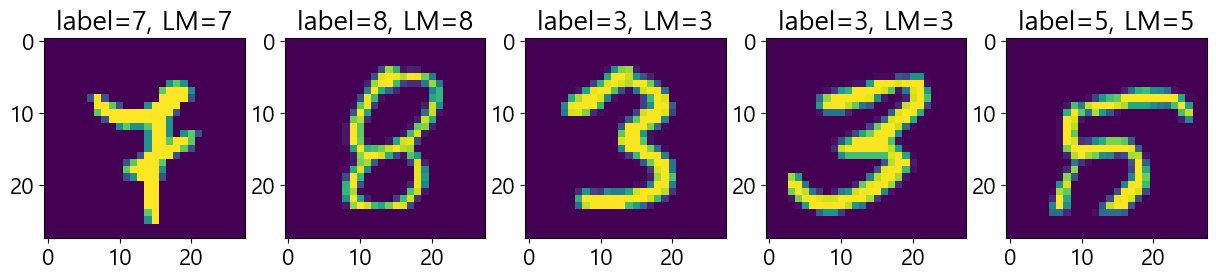

In [19]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3), dpi=100)

for i in range(0, len(ax)):
    train = x_test[i]
    label = y_test[i]
    ax[i].imshow(train)
    ax[i].set_title("label=%d, LM=%d" % (label, arg_result[i]))

plt.show()
plt.close()

### 결과 데이터 셋 구성

### 실제 결과값과 머신러닝에 의한 예측값 비교